In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.tri as tri
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale
from statsmodels.base.model import GenericLikelihoodModel
%matplotlib inline

In [2]:
pklfile = '../learn/pkl_trainsets/19aug2019_opusupdate/mlecompare_not-scaled_15nuc.pkl'
XY = pd.read_pickle(pklfile)
XY.reset_index(inplace=True, drop=True)
if 'total' in XY.columns:
    XY.drop('total', axis=1, inplace=True)
lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']

### Replace nuclide concentrations with ratios

- cs137/cs133
- cs134/cs137
- cs135/cs137
- ba136/ba138
- sm150/sm149
- sm152/sm149
- eu154/eu153
- pu240/pu239
- pu241/pu239
- pu242/pu239

In [3]:
ratios = XY.loc[:, lbls].copy()

In [5]:
#cs137/cs133
ratios['cs137/cs133'] = XY['cs137'] / XY['cs133']
#cs134/cs137
ratios['cs134/cs137'] = XY['cs134'] / XY['cs137']
#cs135/cs137
ratios['cs135/cs137'] = XY['cs135'] / XY['cs137']
#ba136/ba138
ratios['ba136/ba138'] = XY['ba136'] / XY['ba138']
#sm150/sm149
ratios['sm150/sm149'] = XY['sm150'] / XY['sm149']
#sm152/sm149
ratios['sm152/sm149'] = XY['sm152'] / XY['sm149']
#eu154/eu153
ratios['eu154/eu153'] = XY['eu154'] / XY['eu153']
#pu240/pu239
ratios['pu240/pu239'] = XY['pu240'] / XY['pu239']
#pu241/pu239
ratios['pu241/pu239'] = XY['pu241'] / XY['pu239']
#pu242/pu239
ratios['pu242/pu239'] = XY['pu242'] / XY['pu239']

ratios.replace([np.inf, -np.inf], 0, inplace=True)
ratios.fillna(0, inplace = True)
#ratios

In [6]:
### filter trainXY ###
#Need to explicitly tell pandas not to worry that I'm making a copy
trainXY = ratios.loc[ratios['Burnup'] > 0].copy()
trainXY = trainXY.sample(frac=0.2)
trainXY.shape

(14629, 15)

In [7]:
def splitXY(dfXY):
    lbls = ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']
    dfX = dfXY.drop(lbls, axis=1)
    r_dfY = dfXY.loc[:, lbls[0]]
    c_dfY = dfXY.loc[:, lbls[1]]
    e_dfY = dfXY.loc[:, lbls[2]]
    b_dfY = dfXY.loc[:, lbls[3]]
    o_dfY = dfXY.loc[:, lbls[4]]
    return dfX, r_dfY, c_dfY, e_dfY, b_dfY, o_dfY

X, rY, cY, eY, bY, oY = splitXY(trainXY)

In [8]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
5225,pwr,2115.331541,3.100,6233.69,ce14x14,0.823978,0.003624,0.293122,0.003550,18.568061,9.457867,0.051846,0.126316,0.031483,0.002429
49321,agr,2065.129838,3.630,7636.02,agr,0.816128,0.003783,0.561889,0.005033,33.965368,17.376623,0.052205,0.217620,0.059855,0.007503
32437,pwr,3573.968575,3.740,7553.51,vver1000,0.755898,0.001345,0.341657,0.004466,21.306478,10.745781,0.043534,0.142047,0.037474,0.004237
3727,pwr,2141.987309,3.100,4174.53,ce14x14,0.816788,0.002329,0.293379,0.002711,11.819256,5.942115,0.039029,0.089262,0.015161,0.000760
58578,phwr,4800.873277,0.711,6624.81,candu19,0.684395,0.000165,0.395235,0.002249,31.231814,18.128031,0.023398,0.114456,0.006762,0.000747
42780,agr,1839.276416,3.630,930.09,agr,0.821441,0.000589,0.547537,0.001385,3.459485,1.470925,0.011136,0.030681,0.001175,0.000015
40989,agr,3979.548736,3.090,7636.02,agr,0.722370,0.000695,0.621175,0.004798,35.257453,18.256549,0.033153,0.223994,0.044599,0.007284
26125,pwr,688.501729,3.740,1524.67,vver1000,0.887160,0.002687,0.282292,0.001643,3.799503,1.783985,0.024007,0.034703,0.002952,0.000044
59780,phwr,1503.544757,0.711,8282.21,candu19,0.843335,0.003549,0.315521,0.002638,38.358491,22.594340,0.056809,0.146643,0.016705,0.001574
39094,agr,113.995913,3.090,5947.53,agr,0.920429,0.015132,0.486389,0.003976,27.013575,13.773756,0.067400,0.180872,0.047805,0.003474


# ML Calculation
## Likelihoods of each observation calculated for a single comparison

In [10]:
### If random filtering: make sure sample isn't in training set ###
sim_idx = 43552
test_exist = trainXY.loc[trainXY.index == sim_idx]
test_exist

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239


In [11]:
test_sample = ratios.loc[ratios.index == sim_idx].drop(lbls, axis=1)
test_answer = ratios.loc[ratios.index == sim_idx, lbls]
test_answer
#test_sample

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43552,agr,4943.330778,3.63,1604.81,agr


In [12]:
def ll_calc(y_sim, y_mes, std):
    ll = np.sum(stats.norm.logpdf(y_sim, loc=y_mes, scale=std))
    return ll

def unc_calc(y_sim, y_mes, sim_unc_sq, mes_unc_sq):
    unc = ((y_sim - y_mes) / sim_unc_sq)**2 * (sim_unc_sq + mes_unc_sq)
    unc.replace([np.inf, -np.inf], 0, inplace=True)
    unc.fillna(0, inplace = True)
    return np.sqrt(unc.sum(axis=1))

In [13]:
row_unc = 0.14
test_unc = 0.14
trainXY['LogLikelihood'] = X.apply(lambda row: ll_calc(row, test_sample.iloc[0], row_unc*row), axis=1)
#############################################################################
# pandas converts each row to a series, so using .iloc[0] on the single-row #
# dataframe that is test_sample allows the function to work properly        #
#############################################################################

In [14]:
trainXY['LLUncertainty'] = X.apply(lambda row: unc_calc(row, test_sample.iloc[0], (row_unc*row)**2, (test_unc*test_sample)**2), axis=1)

In [15]:
trainXY.sample(10)

,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239,LogLikelihood,LLUncertainty
49633,agr,294.162541,3.63,7926.34,agr,0.913248,0.017791,0.502574,0.005178,35.543951,18.189730,0.078748,0.224204,0.080654,0.008359,-134.291010,18.375022
48192,agr,876.700528,3.63,6094.03,agr,0.878520,0.008542,0.520365,0.004248,26.251067,13.287788,0.059682,0.180519,0.047288,0.003879,-116.982207,17.580453
10910,pwr,3777.891213,3.69,3189.70,ce14x14,0.734584,0.000459,0.337495,0.002418,8.663540,4.223329,0.023039,0.069461,0.007959,0.000371,-47.110899,19.488674
46595,agr,5923.273947,3.63,4142.81,agr,0.637419,0.000080,0.712930,0.003222,17.732049,8.618214,0.015354,0.128364,0.012009,0.001248,-40.522396,13.224735
1064,pwr,561.374698,3.10,1854.07,ce14x14,0.895608,0.003503,0.267082,0.001681,4.986650,2.342657,0.028288,0.041755,0.004016,0.000071,-61.913959,30.717113
13420,pwr,3891.627141,3.69,5098.00,ce14x14,0.734043,0.000690,0.341395,0.003285,13.901494,6.983951,0.031706,0.104369,0.018447,0.001429,-90.019286,21.082610
21595,pwr,508.483317,2.99,5818.52,vver1000,0.910839,0.013225,0.265451,0.003459,16.451247,8.463719,0.069353,0.120019,0.033673,0.001935,-152.928281,33.370144
24816,pwr,2476.344520,2.99,8251.85,vver1000,0.810710,0.003476,0.301639,0.004392,23.103076,11.856449,0.056007,0.157462,0.047177,0.005219,-145.693515,26.945289
9395,pwr,3629.379459,3.69,1609.97,ce14x14,0.737093,0.000229,0.336709,0.001638,4.102804,1.919003,0.013242,0.036542,0.002228,0.000051,-16.777360,21.128780
48077,agr,5273.771285,3.63,5947.53,agr,0.665348,0.000194,0.686576,0.004172,26.129032,13.190933,0.022297,0.176780,0.025266,0.003615,-80.922403,15.658629


### Max LL: Reactor-dependent (paper presents it this way)

#### PWR

In [16]:
max_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].max()
idx_pwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'pwr'].idxmax()
unc_pwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_pwr])
print(f'Max Log Likelihood for PWRs: {max_pwr} +/- {unc_pwr}')
trainXY.loc[trainXY.index == idx_pwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PWRs: 25.405880413981045 +/- 13.093606936055801


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
9996,pwr,5332.714433,3.69,1854.07,ce14x14


#### AGR

In [17]:
max_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].max()
idx_agr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'agr'].idxmax()
unc_agr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_agr])
print(f'Max Log Likelihood for AGRs: {max_agr} +/- {unc_agr}')
trainXY.loc[trainXY.index == idx_agr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for AGRs: 47.39156884686299 +/- 0.6397152518871576


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
43554,agr,5010.25989,3.63,1604.81,agr


#### PHWR

In [18]:
max_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].max()
idx_phwr = trainXY['LogLikelihood'].loc[trainXY['ReactorType'] == 'phwr'].idxmax()
unc_phwr = float(trainXY['LLUncertainty'].loc[trainXY.index == idx_phwr])
print(f'Max Log Likelihood for PHWRs: {max_phwr} +/- {unc_phwr}')
trainXY.loc[trainXY.index == idx_phwr, ['ReactorType', 'CoolingTime', 'Enrichment', 'Burnup', 'OrigenReactor']]

Max Log Likelihood for PHWRs: 14.605757139805059 +/- 12.24164626787595


,ReactorType,CoolingTime,Enrichment,Burnup,OrigenReactor
65095,phwr,4683.894096,0.711,2831.03,candu37


## LL wrt Burnup and Cool Time

In [20]:
min_ll = trainXY['LogLikelihood'].min()
med_ll = trainXY['LogLikelihood'].median()
mean_ll = trainXY['LogLikelihood'].mean()
max_ll = trainXY['LogLikelihood'].max()
min_ll, med_ll, mean_ll, max_ll

(-7946980.965779796,
 -107.00454254460293,
 -84067.37253102384,
 47.39156884686299)

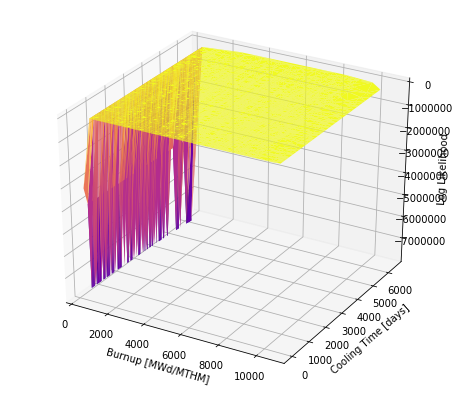

In [19]:
x = trainXY['Burnup']
y = trainXY['CoolingTime']
triang = tri.Triangulation(x, y)
z = trainXY['LogLikelihood']

fig = plt.figure(figsize=(8, 7))
ax = fig.gca(projection='3d')
ax.plot_trisurf(triang, z, linewidth=0.1, cmap=plt.cm.plasma)
#ax.scatter(x, y, z)
ax.set_xlabel('Burnup [MWd/MTHM]')
ax.set_ylabel('Cooling Time [days]')
ax.set_zlabel('Log Likelihood')
plt.show()

# ML Estimation
## Coefficients of linear models estimated
This example is done with dependent variable = burnup

In [21]:
class NormMod(GenericLikelihoodModel):
    def __init__(self, endog, exog, **kwds):
        super(NormMod, self).__init__(endog, exog, **kwds)
    
    def nloglikeobs(self, params):
        beta = params
        yhat = np.dot(self.exog, beta)
        LL = stats.norm.logpdf(self.endog, loc=yhat)
        return -LL
    
    def fit(self, start_params=None, maxiter=100000, maxfun=100000, **kwds):
        if start_params == None:
            start_params = np.zeros(self.exog.shape[1])
            start_params[0] = np.log(self.endog.mean())
        return super(NormMod, self).fit(start_params=start_params,
                                        maxiter=maxiter, maxfun=maxfun,
                                        **kwds)
    
    def predict(self, nuc_list):
        
        return burn

In [22]:
y = bY
X = sm.add_constant(X)

/home/opotowsky/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
X.shape

(14629, 11)

In [24]:
X

,const,cs137/cs133,cs134/cs137,cs135/cs137,ba136/ba138,sm150/sm149,sm152/sm149,eu154/eu153,pu240/pu239,pu241/pu239,pu242/pu239
53806,1.0,0.823392,0.000721,0.342803,0.001343,10.968661,5.628680,0.020296,0.040731,0.001372,3.431042e-05
28420,1.0,0.749728,0.000705,0.335512,0.002772,10.612981,5.221154,0.027415,0.080265,0.010929,5.689857e-04
61655,1.0,0.913999,0.013757,0.284238,0.003233,54.132357,32.032124,0.088586,0.195413,0.033621,3.776233e-03
54166,1.0,0.898284,0.002690,0.313029,0.001412,11.777379,6.193896,0.030624,0.046300,0.002115,5.029059e-05
729,1.0,0.806251,0.000714,0.297304,0.001567,4.238126,1.985237,0.017304,0.036391,0.002463,4.720175e-05
27384,1.0,0.761687,0.000536,0.327977,0.002041,5.970571,2.839640,0.019812,0.050784,0.004537,1.376314e-04
62475,1.0,0.749282,0.000023,0.401342,0.000911,1.344025,0.713399,0.002719,0.006795,0.000037,1.943396e-07
686,1.0,0.828607,0.001036,0.289283,0.001567,4.238126,1.985237,0.019040,0.036408,0.002608,4.718886e-05
66783,1.0,0.847470,0.002108,0.328358,0.001862,19.971751,11.026365,0.036554,0.084623,0.006106,2.880040e-04
53676,1.0,0.892788,0.002162,0.316157,0.001343,10.968661,5.628680,0.026941,0.040748,0.001627,3.431042e-05


In [25]:
mod = NormMod(y, X)

In [26]:
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 545458.327359
         Iterations: 1704
         Function evaluations: 2503
                               NormMod Results                                
Dep. Variable:                 Burnup   Log-Likelihood:            -7.9795e+09
Model:                        NormMod   AIC:                         1.596e+10
Method:            Maximum Likelihood   BIC:                         1.596e+10
Date:                Mon, 26 Aug 2019                                         
Time:                        12:39:45                                         
No. Observations:               14629                                         
Df Residuals:                   14618                                         
Df Model:                          10                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

/home/opotowsky/.local/lib/python3.6/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/opotowsky/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [27]:
res.params

array([ 152.78657995,  573.3246519 ,    9.28999576,  296.89667871,
       -466.11324286,  578.71779207, -664.32524069, -397.83215989,
        170.26901221, -109.53584399, -515.51328671])

In [28]:
test_sample.insert(0, 'const', 1.0)

In [29]:
burn_pred = np.sum(test_sample.iloc[0] * res.params)
burn_pred, test_answer['Burnup']

(2692.582140167781, 43552    1604.81
 Name: Burnup, dtype: float64)